In [668]:
import warnings
warnings.filterwarnings('ignore')

In [669]:
# 데이터 핸들링
import numpy as np 
import pandas as pd 

# 시각화
import matplotlib.pyplot as plt

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,RobustScaler
from sklearn.model_selection import train_test_split 

#하이퍼 파라미터 튜닝: 보통 랜덤서치로 대략 파악한 다음 그리드 서치로 미세조정
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# 모델
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

# 평가도구 
from sklearn.metrics import accuracy_score

In [670]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [671]:
train2= train.copy()
train2=train2.drop('id',axis=1)
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.1+ MB


In [672]:
categorical_cols=['Stage_fear','Drained_after_socializing']
cols= train2.columns
numerical_cols=[col for col in cols if train2[col].dtype != 'object']
numerical_cols

['Time_spent_Alone',
 'Social_event_attendance',
 'Going_outside',
 'Friends_circle_size',
 'Post_frequency']

In [673]:
# 1단계: 범주형 변수 결측치 채우기
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

train3 = train2.copy()

label_encoders = {}

# 1. 모든 범주형 열(대상 포함)에 대해 astype(str) + LabelEncoding 적용
for col in train3.columns:
    if train3[col].dtype == 'object' or train3[col].isnull().any():
        train3[col] = train3[col].astype(str)  # NaN -> 'nan' 문자열 변환
        le = LabelEncoder()
        train3[col] = le.fit_transform(train3[col])
        label_encoders[col] = le

# 2. Stage_fear 결측치 예측
mask_sf = train2['Stage_fear'].notnull()
known_sf = train3[mask_sf]
unknown_sf = train3[~mask_sf]

if not unknown_sf.empty:
    X_sf_train = known_sf.drop('Stage_fear', axis=1)
    y_sf_train = known_sf['Stage_fear']
    X_sf_pred = unknown_sf.drop('Stage_fear', axis=1)

    clf_sf = RandomForestClassifier(random_state=42)
    clf_sf.fit(X_sf_train, y_sf_train)
    pred_sf = clf_sf.predict(X_sf_pred)

    # 역변환 후 train2에 채우기
    train2.loc[~mask_sf, 'Stage_fear'] = label_encoders['Stage_fear'].inverse_transform(pred_sf)

# 3. Drained_after_socializing 결측치 예측
mask_dr = train2['Drained_after_socializing'].notnull()
known_dr = train3[mask_dr]
unknown_dr = train3[~mask_dr]

if not unknown_dr.empty:
    X_dr_train = known_dr.drop('Drained_after_socializing', axis=1)
    y_dr_train = known_dr['Drained_after_socializing']
    X_dr_pred = unknown_dr.drop('Drained_after_socializing', axis=1)

    clf_dr = RandomForestClassifier(random_state=42)
    clf_dr.fit(X_dr_train, y_dr_train)
    pred_dr = clf_dr.predict(X_dr_pred)

    train2.loc[~mask_dr, 'Drained_after_socializing'] = label_encoders['Drained_after_socializing'].inverse_transform(pred_dr)

In [674]:
#2단계: 숫자형 변수 결측치 채우기

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train2_filled = train2[numerical_cols].fillna(train2[numerical_cols].mean())

#5개의 숫자형 변수를 다 더해줌(단,혼자 있는 시간은 적을수록 내향적이므로 -를 붙여줌)
train2['Extroversion_Score'] = (
    -train2_filled['Time_spent_Alone'] +
     train2_filled['Social_event_attendance'] +
     train2_filled['Going_outside'] +
     train2_filled['Friends_circle_size'] +
     train2_filled['Post_frequency']
)

# 이제 Extroversion_Score 포함한 변수 리스트
cols_for_impute = numerical_cols + ['Extroversion_Score']

# IterativeImputer로 결측치 한꺼번에 채우기
imp = IterativeImputer(random_state=42)
imputed_array = imp.fit_transform(train2[cols_for_impute])

# 결과를 데이터프레임으로 변환
train2_imputed = pd.DataFrame(imputed_array, columns=cols_for_impute)

# 원본 train2에 덮어쓰기
for col in cols_for_impute:
    train2[col] = train2_imputed[col]


In [675]:
train2.isnull().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
Extroversion_Score           0
dtype: int64

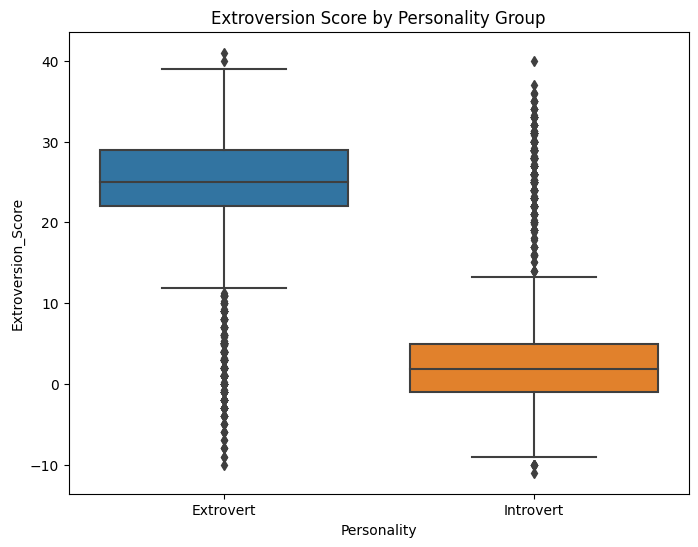

In [676]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(data=train2, x='Personality', y='Extroversion_Score')
plt.title('Extroversion Score by Personality Group')
plt.show()


In [677]:
for group in train2['Personality'].unique():
    sub_df = train2[train2['Personality'] == group]
    
    Q1 = sub_df['Extroversion_Score'].quantile(0.25)
    Q3 = sub_df['Extroversion_Score'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = sub_df[(sub_df['Extroversion_Score'] < lower_bound) | (sub_df['Extroversion_Score'] > upper_bound)]
    ratio = len(outliers) / len(sub_df)
    
    print(f"Personality: {group}, Outlier ratio: {ratio:.2%}")


Personality: Extrovert, Outlier ratio: 2.04%
Personality: Introvert, Outlier ratio: 6.45%


In [678]:
train2.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Extroversion_Score
0,0.0,No,6.0,4.0,No,15.0,5.000000,Extrovert,30.000000
1,1.0,No,7.0,3.0,No,10.0,8.000000,Extrovert,27.000000
2,6.0,Yes,1.0,0.0,Yes,3.0,0.000000,Introvert,-2.000000
3,3.0,No,7.0,3.0,No,11.0,5.000000,Extrovert,23.000000
4,1.0,No,4.0,4.0,No,13.0,4.982097,Extrovert,24.982097


In [679]:
le = LabelEncoder()
train2['Stage_fear'] = le.fit_transform(train2['Stage_fear'])
train2['Drained_after_socializing'] = le.fit_transform(train2['Drained_after_socializing'])

scaler = StandardScaler()
train2['Extroversion_Score_scaled'] = scaler.fit_transform(train2[['Extroversion_Score']])


train2['Personality'] = le.fit_transform(train2['Personality'])


In [680]:
X = train2[['Stage_fear', 'Drained_after_socializing', 'Extroversion_Score_scaled']]
y = train2['Personality']

In [681]:
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

In [682]:
train2.isnull().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
Extroversion_Score           0
Extroversion_Score_scaled    0
dtype: int64

In [683]:
# 기본모델 
lr = LogisticRegression(solver='lbfgs', max_iter=100, random_state=123).fit(X=x_train, y=y_train)

y_pred = lr.predict(x_test)

train_score = lr.score(x_train, y_train)
val_score = lr.score(x_val, y_val)

differ = round((train_score-val_score),3)

if not differ<=0.05:
    print(differ,'=> 과적합')
else:
    print(differ,'=> 과적합 아님')

print('accuracy =',round(accuracy_score(y_test,y_pred),4)) 

-0.004 => 과적합 아님
accuracy = 0.9676
